#**Data Analysis with Python [CS 65 W]**
###Eric Armstrong
---
##2019 StackOverflow Developer Survey Analysis 
---


#**Introduction**

> For the past few years, I've been working in the field of in-house technical recruiting. I help companies hire for software engineering positions that might be difficult to fill or that don't see the volume and quality of incoming applications they'd like. My day-to-day often consists of finding and engaging software developers through a variety of means, predominately online. With any luck, these software engineers are open to interviewing and potentially accepting an offer if interviews go well. 



> From full-stack, to data scientists & machine learning, infrastructure, mobile, and more, I've taken part in hiring for a range of positions within sofware engineering, and I've always been impressed with the diversity of backgrounds and technologies used in the various areas of the stack.




> In many ways, the recruiting industry has plenty of room to grow when it comes to matching developers to the right types of roles. Currently, companies rely on in-house and agency recruiters to find candidates and fill open roles, but in the future, automation may be relied upon more heavily for the discovery and assessment of future employees, especially as remote work opens up exponentially more options for developers and employers. 


> In order to get a more detailed and nuanced understanding of software engineers, I chose to do this analysis of the 2019 StackOverflow Developer Survey. The dataset can be downloaded and accessed here: https://insights.stackoverflow.com/survey

> "*With nearly 90,000 responses fielded from over 170 countries and dependent territories, our 2019 Annual Developer Survey examines all aspects of the developer experience from career satisfaction and job search to education and opinions on open source software.*"

























##Let's Get Started


###Getting set up: 
> This involves setting up Google Authentication so we'll be able to access the survey data currently stored in Google Drive. We'll also import any libraries and frameworks needed. 













In [0]:
#GETTING SET UP: This block intalls and sets up Google Authentication, the first step to allow the file to be pulled from my drive. 
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#GETTING SET UP: This block imports and mounts Google Drive through File Stream. 
#Go to the link, select the account you are using, and copy and paste the authorization code. 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#GETTING SET UP: Here, we're importing the libraries and packages that will be needed later. 
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas_profiling
import pydotplus 
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn import decomposition, preprocessing, cluster, tree
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
import missingno as mn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


##Creating the Data Frame: Part 1

> We'll store the survey as a Pandas dataframe, and in the block after that we'll select the survey columns we'd like to use in our analysis.

In [0]:
#CREATING THE DATA FRAME: This block reads the csv file containing the survey dataset and stores it as a Pandas Dataframe. 
path = "/content/gdrive/My Drive/Data/survey_results_public.csv"
df = pd.read_csv(path)

In [0]:
#CREATING THE DATA FRAME: Here, we are selecting the columns we'd like to focus on with our first analysis. 
df = df[['Age','Country','OrgSize','YearsCode','YearsCodePro', 'EdLevel', 'CareerSat', 'JobSat', 'LastHireDate', 'ConvertedComp', 'WorkWeekHrs']]

In [0]:
#CREATING THE DATA FRAME: Let's take a quick look at the data and what responses look like. 
#88,888 responses, impressive!
df


,Age,Country,OrgSize,YearsCode,YearsCodePro,EdLevel,CareerSat,JobSat,LastHireDate,ConvertedComp,WorkWeekHrs
0,14.0,United Kingdom,NaN,4,NaN,Primary/elementary school,NaN,NaN,NaN,NaN,NaN
1,19.0,Bosnia and Herzegovina,NaN,NaN,NaN,"Secondary school (e.g. American high school, G...",NaN,NaN,I've never had a job,NaN,NaN
2,28.0,Thailand,100 to 499 employees,3,1,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Slightly satisfied,Slightly satisfied,1-2 years ago,8820.0,40.0
3,22.0,United States,100 to 499 employees,3,Less than 1 year,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Very satisfied,Slightly satisfied,Less than a year ago,61000.0,80.0
4,30.0,Ukraine,"10,000 or more employees",16,9,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Very dissatisfied,Slightly dissatisfied,Less than a year ago,NaN,55.0
...,...,...,...,...,...,...,...,...,...,...,...
88878,NaN,Canada,NaN,NaN,NaN,Primary/elementary school,NaN,NaN,NaN,NaN,NaN
88879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##Cleaning the Data: Part 1

> See each block for a description of what is being dropped / filled / encoded and why. 

In [0]:
#CLEANING THE DATA: Clearly, not every respondent answered all the survey questions. Before we go further, there's a useful question we can ask: 
#What percentage of questions are missing?
df.isna().mean() * 100

Age              10.882846
Country           0.148510
OrgSize          19.229774
YearsCode         1.063195
YearsCodePro     16.372085
EdLevel           2.804811
CareerSat        18.041695
JobSat           20.133209
LastHireDate     10.158298
ConvertedComp    37.194964
WorkWeekHrs      27.429317
dtype: float64

In [0]:
#I want to see all the different levels of education. Later I can assign each of these different levels a numerical value. 
df.EdLevel.unique()

array(['Primary/elementary school',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Bachelor’s degree (BA, BS, B.Eng., etc.)',
       'Some college/university study without earning a degree',
       'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
       'Other doctoral degree (Ph.D, Ed.D., etc.)', nan,
       'Associate degree', 'Professional degree (JD, MD, etc.)',
       'I never completed any formal education'], dtype=object)

In [0]:
#CLEANING THE DATA: 

#Drop rows with any values missing ("Going Nuclear!")
#I realize there are several ways I could fill in or approximate missing values, but for now there are plenty of responses to work with. 
#After these drops, there will still be 12984 responses to analyze.
df = df.dropna()

#For now, I am only interested in looking at developers in the USA. This is the main focus of my work, and this is what will bring the most value for the type of company I work for. 
df =df[df.Country == 'United States']

#I want to remove rows were compensation is under $1000 per year. I'm specifically interested in career/professional developers for this analysis
#During my investigation, I also noticed that a highly disproportionate number of respondents were reporting earning exactly 1 Million or 2 Million per year. 
#I am dropping these responses because I do not know which are being honest and what few of them actually make these amounts. 
df = df[df.ConvertedComp >1000]
df = df[df.ConvertedComp !=1000000]
df = df[df.ConvertedComp !=2000000]

#I want to remove anyone who reports working more than 168 hours per week, as this is not physically possible.
df = df[df.WorkWeekHrs < 168]

#I want to remove anyone reporting an age of more than 80. That's a little bit above where age tops out. There are several jokers claiming to be 100 years old. 
df = df[df.Age < 80]

#I want to remove anyone reporting an age of less than 15, as it's extremely unlikely anyone this age is taking a developer survey.
df = df[df.Age > 15]



In [0]:
#CLEANING THE DATA

#Here we are creating a function that transforms the contents of each of the columns. 
#This involves assigning values to categorical or ordinal responses, changing data types, and renaming a column

def tweak_survey(df):
  
  Age = (df.Age
         .astype(int))

  OrgSize = (df.OrgSize
             .replace({'Just me - I am a freelancer, sole proprietor, etc.':1, 
                       '2-9 employees':2,
                       '10 to 19 employees':3, 
                       '20 to 99 employees':4, 
                       '100 to 499 employees':5,
                       '500 to 999 employees':6,
                       '1,000 to 4,999 employees':7, 
                       '5,000 to 9,999 employees':8, 
                       '10,000 or more employees':9})
             .astype(int))
  
  EdLevel = (df.EdLevel
               .replace({'I never completed any formal education':0,
                         'Primary/elementary school':6,
                         'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)':12,
                         'Associate degree':14,
                         'Some college/university study without earning a degree':14,
                         'Bachelor’s degree (BA, BS, B.Eng., etc.)':16,
                         'Professional degree (JD, MD, etc.)':17,
                         'Master’s degree (MA, MS, M.Eng., MBA, etc.)':18,
                         'Other doctoral degree (Ph.D, Ed.D., etc.)':21})
                .astype(int))
  
  YearsCode = (df.YearsCode
               .replace({'Less than 1 year':0, 
                         'More than 50 years': 50})
               .astype(int))
  
  YearsCodePro = (df.YearsCodePro
                  .replace({'Less than 1 year':0, 
                            'More than 50 years': 50})
                  .astype(int))
  
  CareerSat = (df.CareerSat
               .replace({'Very dissatisfied':-2, 
                         'Slightly dissatisfied':-1,
                         'Neither satisfied nor dissatisfied':0, 
                         'Slightly satisfied':1, 
                         'Very satisfied':2,})
               .astype(int))
  
  JobSat = (df.JobSat
            .replace({'Very dissatisfied':-2, 
                      'Slightly dissatisfied':-1,
                      'Neither satisfied nor dissatisfied':0, 
                      'Slightly satisfied':1, 
                      'Very satisfied':2})
            .astype(int))
  
  LastHireDate = (df.LastHireDate
                   .replace({'I\'ve never had a job':0, 
                             'NA - I am an independent contractor or self employed':0,
                             'Less than a year ago':1, 
                             '1-2 years ago':2, 
                             '3-4 years ago':3,
                             'More than 4 years ago':4})
                   .astype(int))
  
  ConvertedComp = (df.ConvertedComp
                    .astype(int))
  

  WorkWeekHrs = (df.WorkWeekHrs
                 .rename('WorkWeekHours')
                 .astype(int))
  
  return pd.concat([Age, OrgSize, EdLevel, YearsCode, YearsCodePro, CareerSat, JobSat, LastHireDate, ConvertedComp, WorkWeekHrs], axis=1)


df2 = tweak_survey(df)

In [0]:
df2

,Age,OrgSize,EdLevel,YearsCode,YearsCodePro,CareerSat,JobSat,LastHireDate,ConvertedComp,WorkWeekHours
3,22,5,16,3,0,2,1,1,61000,80
12,28,3,18,17,8,2,2,3,90000,40
21,47,9,14,35,18,1,-2,4,103000,40
22,22,9,16,3,1,1,1,1,69000,40
25,34,9,14,12,8,2,2,1,114000,40
...,...,...,...,...,...,...,...,...,...,...
88301,27,4,14,8,6,1,1,1,110000,36
88303,27,7,16,9,5,1,1,4,80000,43
88312,36,3,16,15,11,2,2,3,120000,35
88323,23,9,16,8,2,2,1,2,180000,40


In [0]:
#I want to see what types of data I have in each column
df2.dtypes

Age              int64
OrgSize          int64
EdLevel          int64
YearsCode        int64
YearsCodePro     int64
CareerSat        int64
JobSat           int64
LastHireDate     int64
ConvertedComp    int64
WorkWeekHours    int64
dtype: object

#**Analysis: Part 1 & Part 1.1**
#**General Information, Selected Demographics, Plots, and Correlations, and PCA**

> In this first section, we'll be looking at general descriptive information about the respondents. How old they are, what size organization they work in, how many years they've been coding and coding professionally, job and career satisfaction, the date they last changed jobs, compensation, and the hours they work per week



> Please note that in this first section, we are only focusing on developers in the United States. 














##The "Average" Developer & Profiling Report

Here's the picture we can paint of the "average" survey respondent in the USA.

33.3 years old

16 years of education (Bachelor's Degree)

In an organization on the larger end of 500 to 999 employees

14.4 years experience coding (started coding sophomore year of college)

9.3 years coding professionally (coding pro a year out of college)

A little more than 'Slightly satisfied' with their career

A little under 'Slightly satisfied' with their current job

Last changed jobs a little more than 1-2 years ago

Earning just under $165k per year (nice!)

Working nearly 42 hours per week (longer than I thought)

In [0]:
#ANALYSIS: If we want to take a shortcut, we can use the Pandas profiling report to get a general overview of the data. 
#This may give some interesting ideas on what to look into for the analysis. 
#If not, the sections below detail each component
pandas_profiling.ProfileReport(df2)

##Analysis: Part 1 - Basic Stuff
Descriptive Statistics & Plots
> Here we break each question down, look at the descriptive statistics, and find a suitable plot to visualize the data. 



###Age

In [0]:
#ANALYSIS: Age
#What is the general age distribution of respondents? 
df2.Age.describe()

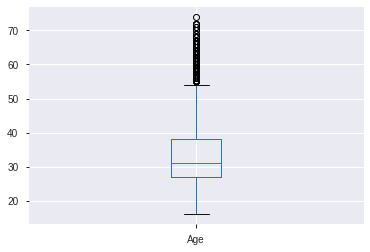

In [0]:
#ANALYSIS: Age - let's make a boxplot 
df2.Age.plot.box()

(array([  2.,   7.,  26.,  36.,  61., 148., 374., 533., 635., 692., 678.,
        737., 695., 705., 712., 630., 616., 543., 481., 512., 453., 422.,
        377., 299., 310., 230., 244., 186., 157., 137., 134., 118., 141.,
        111., 129.,  90.,  90.,  86.,  70.,  79.,  61.,  52.,  56.,  29.,
         49.,  37.,  39.,  32.,  13.,  10.,   6.,   9.,   5.,   2.,   2.,
          2.,   4.,   0.,   1.]),
 array([16.        , 16.98305085, 17.96610169, 18.94915254, 19.93220339,
        20.91525424, 21.89830508, 22.88135593, 23.86440678, 24.84745763,
        25.83050847, 26.81355932, 27.79661017, 28.77966102, 29.76271186,
        30.74576271, 31.72881356, 32.71186441, 33.69491525, 34.6779661 ,
        35.66101695, 36.6440678 , 37.62711864, 38.61016949, 39.59322034,
        40.57627119, 41.55932203, 42.54237288, 43.52542373, 44.50847458,
        45.49152542, 46.47457627, 47.45762712, 48.44067797, 49.42372881,
        50.40677966, 51.38983051, 52.37288136, 53.3559322 , 54.33898305,
        55.3

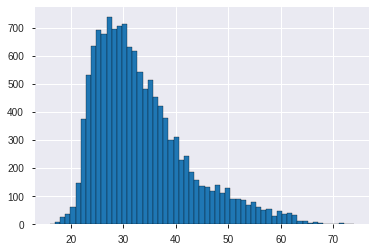

In [0]:
#ANALYSIS: Age -histogram
#Looks like a pretty nice distribution to me
plt.hist(df2['Age'], edgecolor = 'black',
         bins = int(59/1))

###Organization Size

In [0]:
#ANALYSIS: OrgSize
df2.OrgSize.describe()

In [0]:
#ANALYSIS: OgrSize - let's make a boxplot  
df2.OrgSize.plot.box()

(array([ 380.,  823.,  821., 2284., 2466.,  945., 1701.,  720., 2955.]),
 array([1.        , 1.88888889, 2.77777778, 3.66666667, 4.55555556,
        5.44444444, 6.33333333, 7.22222222, 8.11111111, 9.        ]),
 <a list of 9 Patch objects>)

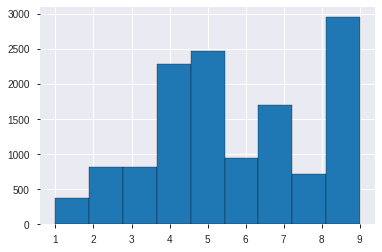

In [0]:
#ANALYSIS: OrgSize -histogram
#Looks like a pretty nice distribution to me
plt.hist(df2['OrgSize'], edgecolor = 'black',
         bins = int(9/1))

###Level of Education / Years of Education
Predominately Bachelor's degree level of education, followed by Master's or Associate's/Some college

In [0]:
#ANALYSIS: Level of Education
#What is the general education distribution of respondents? 
df2.EdLevel.describe()

In [0]:
#ANALYSIS: EdLevel - let's make a boxplot
#Some outliers claiming to have absolutely no education at all
df2.EdLevel.plot.box()

In [0]:
#ANALYSIS: EdLevel - value counts
df2.EdLevel.value_counts(dropna=False)

16    7789
18    2310
14    2175
21     410
12     278
17      58
0       38
6       37
Name: EdLevel, dtype: int64

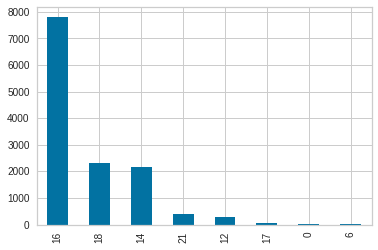

In [0]:
#ANALYSIS: EdLevel - let's make a barplot instead
#That's better!
df2.EdLevel.value_counts(dropna=False).plot(kind='bar')

###Years Spent Coding
Half have under 12 years with a long tail, and blips at five years intervals

In [0]:
#ANALYSIS: Years Spent Coding
df2.YearsCode.describe()

count    13095.000000
mean        14.421459
std          9.827180
min          0.000000
25%          7.000000
50%         12.000000
75%         20.000000
max         50.000000
Name: YearsCode, dtype: float64

In [0]:
#ANALYSIS: Years Spent Coding - boxplot
df2.YearsCode.plot.box()

(array([ 26.,  98., 285., 467., 573., 803., 810., 704., 758., 500., 960.,
        389., 607., 341., 355., 657., 301., 264., 369., 235., 783., 198.,
        266., 182., 146., 333.,  87.,  86., 100.,  50., 298.,  31.,  75.,
         68.,  66., 202.,  68.,  97.,  91.,  40., 137.,  31.,  35.,  26.,
         18.,  30.,   5.,  10.,   8.,  26.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 50 Patch objects>)

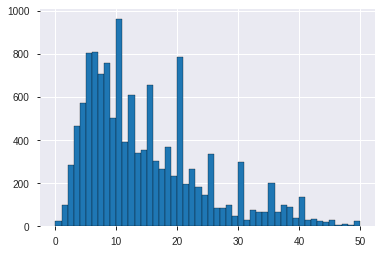

In [0]:
#ANALYSIS: Years Spent Coding -histogram
plt.hist(df2['YearsCode'], edgecolor = 'black', bins = int(50))

###Years Spent Coding Professionally
Half have under 7 years with a long tail, and minor blips at five years intervals

In [0]:
#ANALYSIS: Years of Professional Coding 
df2.YearsCodePro.describe()

count    13095.000000
mean         9.351737
std          8.385073
min          0.000000
25%          3.000000
50%          7.000000
75%         13.000000
max         50.000000
Name: YearsCodePro, dtype: float64

In [0]:
#ANALYSIS: Years of Professional Coding - boxplot
df2.YearsCodePro.plot.box()

(array([ 558.,  640., 1182., 1256., 1071., 1066.,  772.,  625.,  615.,
         335.,  742.,  357.,  422.,  283.,  243.,  388.,  180.,  132.,
         243.,  176.,  461.,  134.,  165.,  122.,   61.,  161.,   57.,
          56.,   44.,   34.,  122.,   25.,   58.,   42.,   29.,   69.,
          26.,   21.,   25.,   19.,   28.,    8.,    9.,   12.,    4.,
           5.,    0.,    3.,    3.,    6.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 50 Patch objects>)

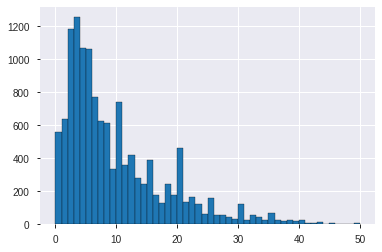

In [0]:
#ANALYSIS: Years of Professional Coding -histogram
plt.hist(df2['YearsCodePro'], edgecolor = 'black',
         bins = int(50))

###Career Satisfaction
Most respondents are very satsified or slightly satisfied with their career.

In [0]:
#ANALYSIS: Careers Satsifaction
df2.CareerSat.describe()

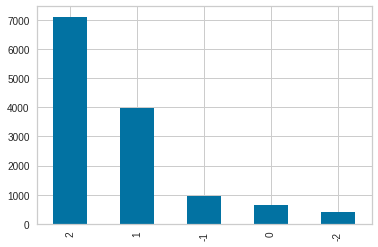

In [0]:
#ANALYSIS: Careers Satsifaction - barplot
df2.CareerSat.value_counts(dropna=False).plot(kind='bar')

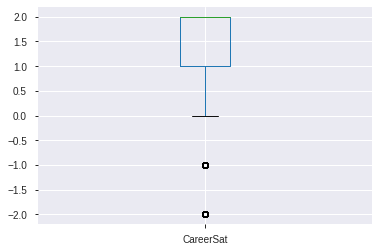

In [0]:
#ANALYSIS: Careers Satsifaction - boxplot
df2.CareerSat.plot.box()

###Job Satsifaction
Most respondents are very satsified or slightly satisfied with their job.

In [0]:
#ANALYSIS: Job Satsifaction
df2.JobSat.describe()

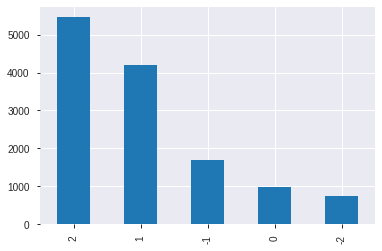

In [0]:
#ANALYSIS: Job Satisfaction - barplot
df2.JobSat.value_counts(dropna=False).plot(kind='bar')

In [0]:
#ANALYSIS:  Job Satsifaction - boxplot
df2.JobSat.plot.box()

###Last Hire Date
Most have changed roles under a year, 1-2 years ago, or more than 4 years ago.

Very few self empoyed people or people who have never had a job.

In [0]:
#ANALYSIS: Last Hire Date
df2.LastHireDate.describe()

In [0]:
#ANALYSIS: Last Hire Date - value counts
df2.LastHireDate.value_counts(dropna=False)

1    3914
2    3466
4    3173
3    2306
0     236
Name: LastHireDate, dtype: int64

In [0]:
#ANALYSIS: Last Hire Date - boxplot
df2.LastHireDate.plot.box()

(array([ 236.,    0., 3914.,    0.,    0., 3466.,    0., 2306.,    0.,
        3173.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

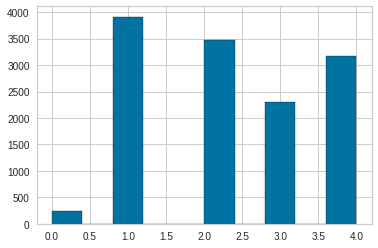

In [0]:
#ANALYSIS: Last Hire Date - histogram
plt.hist(df2['LastHireDate'], edgecolor = 'black')

###Compensation

Now for the part everyone's interested in! 

Half the values fall between 80,000 and 150,000 with many repondents claiming expectionally high incomes. 

Compensation can sometimes be a signal for how 'good' and engineer is at their job. Many of the plots in the next section look for other signals that may influence or be influenced by compensation. 

In [0]:
#ANALYSIS: Compensation
df2.ConvertedComp.describe()

count    1.309500e+04
mean     1.651528e+05
std      2.401809e+05
min      1.050000e+03
25%      8.000000e+04
50%      1.100000e+05
75%      1.500000e+05
max      1.980000e+06
Name: ConvertedComp, dtype: float64

In [0]:
#ANALYSIS: Compensation
#What are the most commonly reported incomes
#They're all landing on nice even numbers
df2.ConvertedComp.value_counts(dropna=False)

120000    441
100000    420
150000    389
80000     353
90000     341
         ... 
59569       1
65652       1
98412       1
110650      1
90100       1
Name: ConvertedComp, Length: 1311, dtype: int64

In [0]:
#ANALYSIS: Compensation - boxplot
df2.ConvertedComp.plot.box()

In [0]:
#ANALYSIS: Compensation - histogram
plt.hist(df2['ConvertedComp'], edgecolor = 'black',
         bins = int(500/1))

In [0]:
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(df2, bins=logbins)
plt.xscale('log')
plt.show()

NameError: ignored

In [0]:
#ANALYSIS: Work Week Hours
df2.WorkWeekHours.describe()

In [0]:
#ANALYSIS: Work Week Hours - boxplot
df2.WorkWeekHours.plot.box()

##Analysis: Part 1.1 - Fancy Stuff
Correlation Coefficients and More Plots
> Here, we can investigate a few relationships by comparing two or more columns through correlations and a variety of plots




###Correlation Matrix
This can give us a few ideas of what to focus on.
The blocks below include a few of these interesting correlations or lack thereof. 

In [0]:
#Doing a plain table first. 
df2.corr()

,Age,OrgSize,EdLevel,YearsCode,YearsCodePro,CareerSat,JobSat,LastHireDate,ConvertedComp,WorkWeekHours
Age,1.000000,-0.020828,0.116145,0.784365,0.835194,-0.018470,-0.022697,0.282893,0.045894,0.097114
OrgSize,-0.020828,1.000000,0.122191,-0.003851,-0.024128,-0.001236,-0.037166,0.129136,0.024323,0.025598
EdLevel,0.116145,0.122191,1.000000,0.070208,0.047608,-0.010940,0.006564,0.057472,0.053384,0.060729
YearsCode,0.784365,-0.003851,0.070208,1.000000,0.891636,-0.007724,-0.002047,0.295909,0.058455,0.098469
YearsCodePro,0.835194,-0.024128,0.047608,0.891636,1.000000,0.007109,-0.004483,0.293201,0.065789,0.103443
CareerSat,-0.018470,-0.001236,-0.010940,-0.007724,0.007109,1.000000,0.612174,-0.016484,0.019307,0.015482
JobSat,-0.022697,-0.037166,0.006564,-0.002047,-0.004483,0.612174,1.000000,-0.097551,0.006274,-0.005410
LastHireDate,0.282893,0.129136,0.057472,0.295909,0.293201,-0.016484,-0.097551,1.000000,0.025619,0.064457
ConvertedComp,0.045894,0.024323,0.053384,0.058455,0.065789,0.019307,0.006274,0.025619,1.000000,0.068043
WorkWeekHours,0.097114,0.025598,0.060729,0.098469,0.103443,0.015482,-0.005410,0.064457,0.068043,1.000000


In [0]:
#Now for a correlation map with a bit more of a visual component
#Looks like there may some slight negative correlation between job satisfaction and last hire date
corr = df2.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

###Age VS Education : 0.116145

There's a weak correlation.

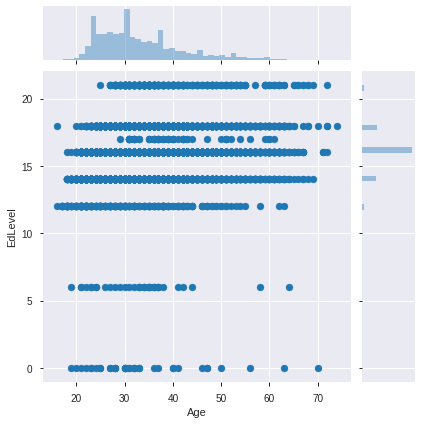

In [0]:
#Combine frequency and scatter plot
sns.jointplot(x='Age', y='EdLevel', data=df2)

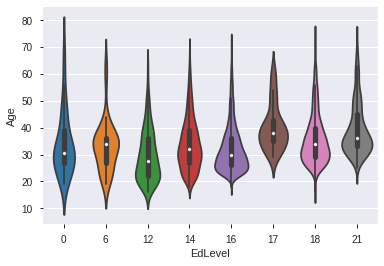

In [0]:
#This one seems to tell a better story of the trend.
ax = sns.violinplot(x="EdLevel", y="Age", data=df2)

###Age VS Last Hire Date : 0.282893
Seems older people have been in or stuck around their jobs longer. 


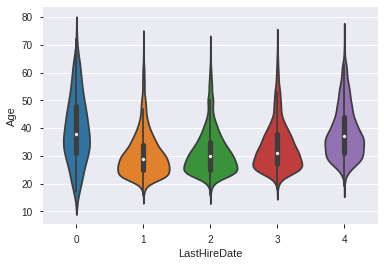

In [0]:
#ANALYSIS PART 1: Age vs Last Hire Date
#This shows a good general picture, but we can include means and error bars in the next graph to give more clarity
ax = sns.violinplot(x="LastHireDate", y="Age", data=df2)

###Age VS Compensation : 0.045894
No correlation, but it's an interesting graph. 

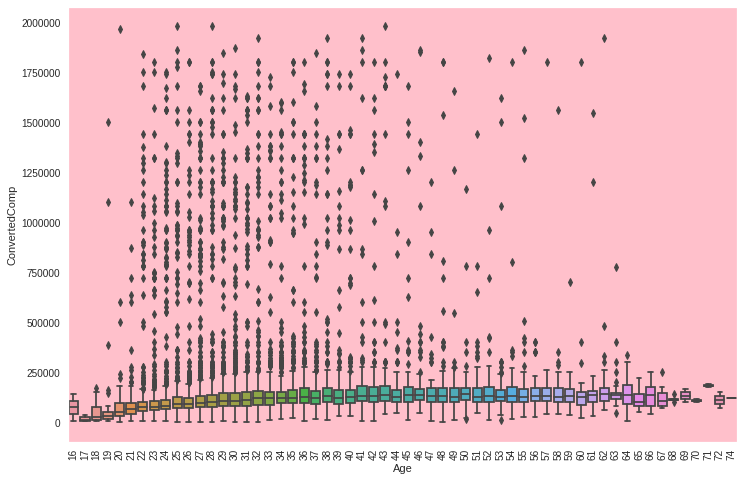

In [0]:
#ANALYSIS PART 1: Age vs Compensation
#Is there a clear relationship between age and compensation?
with sns.axes_style('dark', {'axes.facecolor':'pink'}):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.boxplot(x='Age', y='ConvertedComp', data=df2, ax=ax)
    ax.tick_params(axis='x', labelrotation=90)

###Org Size VS Education : 0.122191
Something of a relationship here.

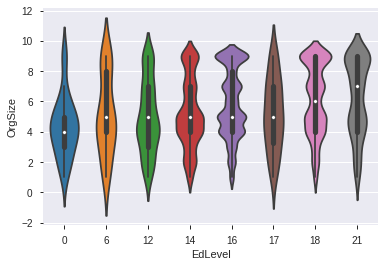

In [0]:
#ANALYSIS PART 1: Level of Education vs Compensation
#Let's plot it
ax = sns.violinplot(x="EdLevel", y="OrgSize", data=df2)

###Org Size and Last Hire Date : 0.129136
This isn't the correlation you're looking for. 

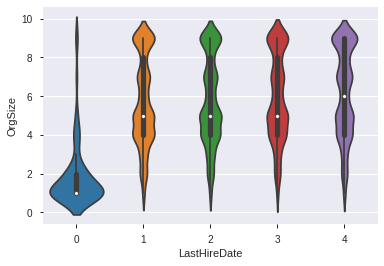

In [0]:
#This makes sense. People who have never had a job / work as consultants / are self-employed do not have a last hire date. 
#This may slight correlation may be a side effect of the way the question is set up. We should exclude the 0's next time.
ax = sns.violinplot(x="LastHireDate", y="OrgSize", data=df2)

###Years Spent Coding VS Years Coding Professionally : 0.891636
The correlation is strong with this one. This is an obvious finding.

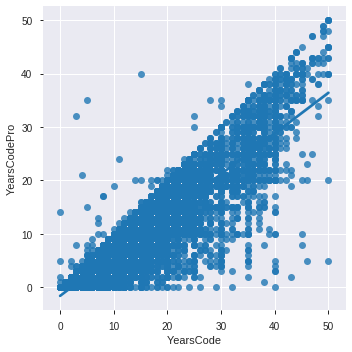

In [0]:
#ANALYSIS PART 1: Years Spent Coding VS. Years Spent Coding Professionally - lmplot with Seaborn 
#Here, we can see there are a few outliers who report spending more years coding professionally than they've spent coding in total...
#Apart from that, the relationship is very clear!
sns.lmplot(x='YearsCode', y='YearsCodePro', data=df2)

###Years Spent Coding VS Last Hire Date : 0.295909
Nearly the same when you swap out Years Spent Coding Professionally

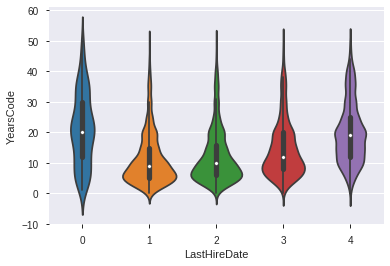

In [0]:
ax = sns.violinplot(x="LastHireDate", y="YearsCode", data=df2)

### Years Spent Coding Professionally VS Compensation : 0.065789
A very weak correlation. 

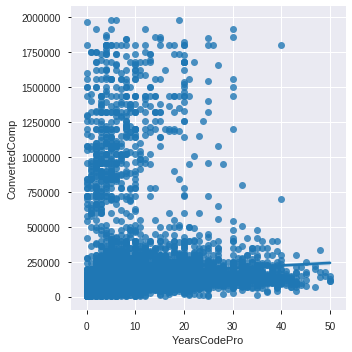

In [0]:
#ANALYSIS PART 1: Years Spent Coding Professionally VS. Compensation
sns.lmplot(x='YearsCodePro', y='ConvertedComp', data=df2)

### Years Spent Coding Professionally VS Work Week Hours : 0.103443

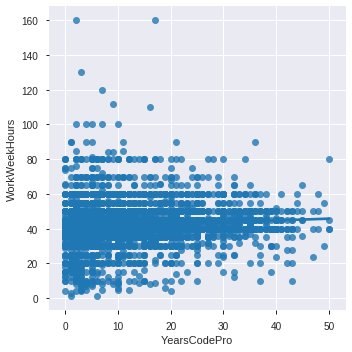

In [0]:
sns.lmplot(x='YearsCodePro', y='WorkWeekHours', data=df2)

###Career Satisfaction VS Job Satisfaction : 0.612174
There's a fairly strong correlation.
And apparently a ton of developers who are very satisfied with their jobs and careers. That's great!

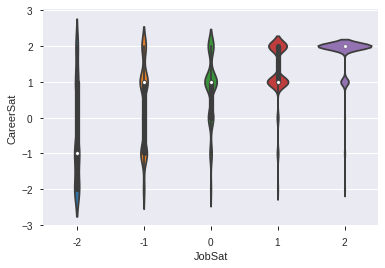

In [0]:
#ANALYSIS PART 1: Job Satisfaction VS Career Satisfaction
ax = sns.violinplot(x="JobSat", y="CareerSat", data=df2)


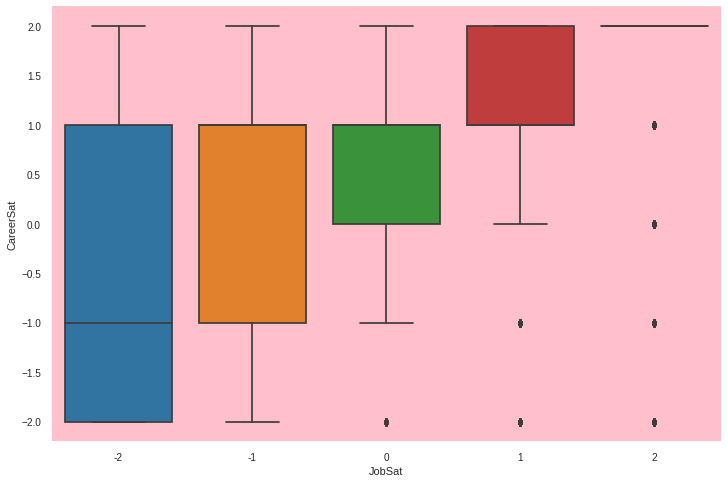

In [0]:
#ANALYSIS: Job Satisfaction VS Career Satisfaction
#Let's try another type of visualization for the same question
with sns.axes_style('dark', {'axes.facecolor':'pink'}):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.boxplot(x='JobSat', y='CareerSat', data=df2, ax=ax)
    ax.tick_params(axis='x')

###Job Satisfaction VS Last Hire Date : -0.097551
There a slight negative correlation. Could be a few things going on...

1) People who have been in their jobs too long are becoming dissatisfied with their work

2) People are more satisfied with their work when they're newer to the organization


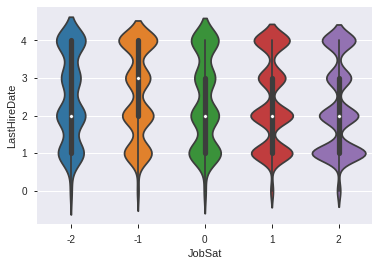

In [0]:
#There might be an explanation for this...
#I like the look of this one much better. It's modern art compared to the scatterplot I started with. 
#I know now when I have a low number of discreet values to compare, this is the way to go!
ax = sns.violinplot(x="JobSat", y="LastHireDate", data=df2)


###Compensation VS Work Week Hours : 0.068043
Is there a clear relationship between how long someone works and the amount they earn? 

In [0]:
df.corr()

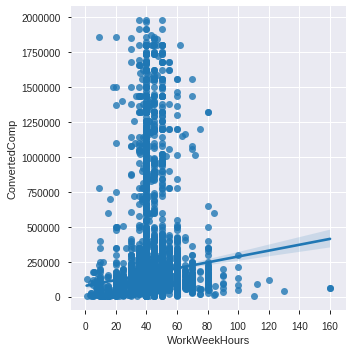

In [0]:
#ANALYSIS PART 1: Work Week Hours VS Compensation
#I feel bad for the person working 160 hours per week and making less than the average compensation... 
sns.lmplot(x='WorkWeekHours', y='ConvertedComp', data=df2)

###Job Satisfaction VS Compensation : 0.006274
Absolutely no correlation, which I was not expecting to see!

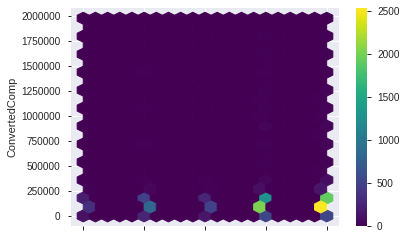

In [0]:
#We suspect that higher job satisfaction may positively correlated with compensation
#Turns out, there is not a very strong correlation!
#ANALYSIS: Job Satisfaction VS Compensation
#Density: not the best visualization in this case...
df2.plot.hexbin(x='JobSat', y='ConvertedComp', gridsize=20, cmap='viridis')

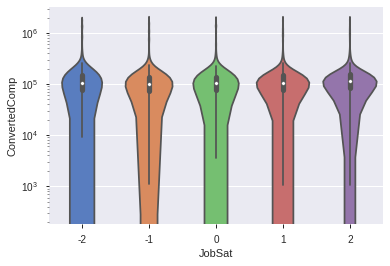

In [0]:
#ANALYSIS: Job Satisfaction VS Compensation
#I'm exporing using a logarithmic scale for this one...
g = sns.violinplot(x="JobSat", y="ConvertedComp",
                data=df2, palette="muted")
g.set_yscale("log")

###Years Professional Coding VS Compensation VS Job Satisfaction [TRIPLE]
Interesting to not see much of a trend or relationship here. 

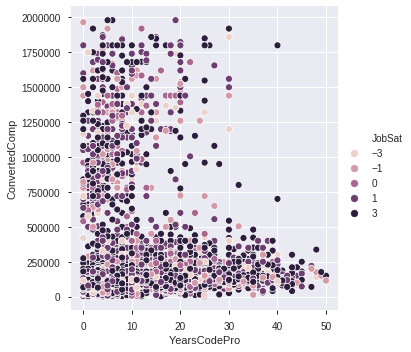

In [0]:
sns.relplot(x='YearsCodePro', y='ConvertedComp', data=df2, hue='JobSat')

###Age VS Compensation VS Job Satisfaction [TRIPLE]

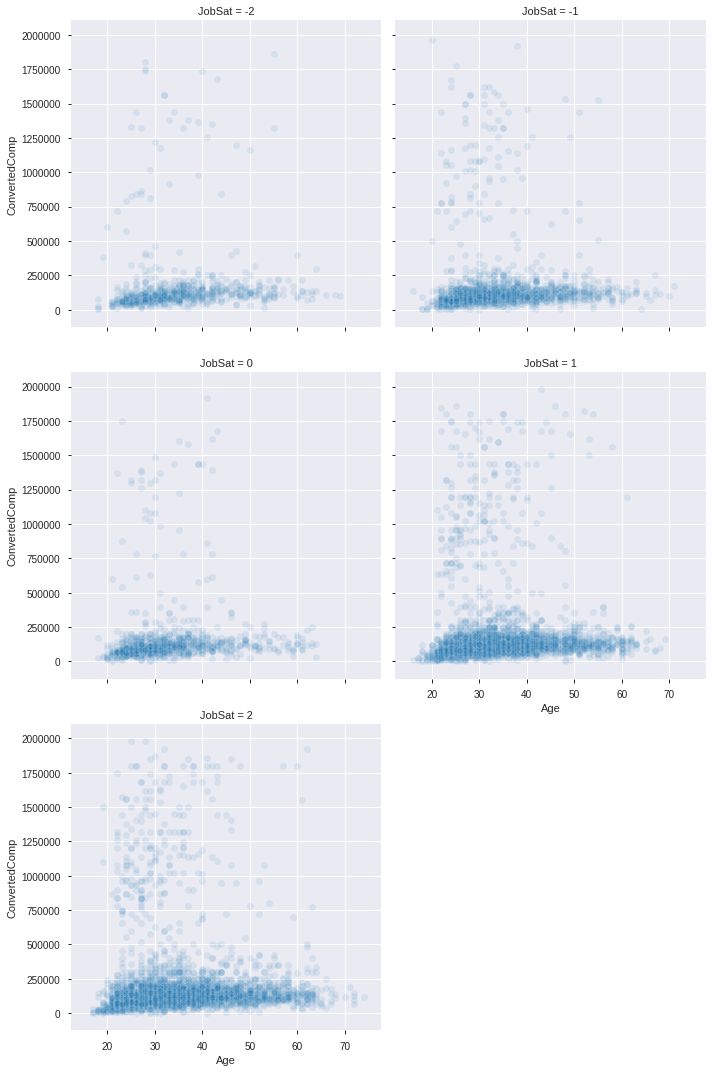

In [0]:
#ANALYSIS: Age VS Compensation VS Job Satisfaciton
#From these graphs, it appears that low job satisfaction may be linked to generally lower compensation outlooks
#The most satisfied respondents also had more outliers for higher compensation :)
sns.relplot(x='Age', y='ConvertedComp', data=df2, col='JobSat', col_wrap=2, alpha=.1)

###Principal Component Analysis
Let's take a look...


In [0]:
#ANALYSIS PART 1 (Principal Component Analysis)
#PCA - passing in rows of features, new dataset will be the embeddings (linear combinations of columns that maximize the variance) 
#Reduces the dimensionality of the data
#Code below standardizes the data
X = df2
std = preprocessing.StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X), columns=X.columns)
X_std

,Age,OrgSize,EdLevel,YearsCode,YearsCodePro,CareerSat,JobSat,LastHireDate,ConvertedComp,WorkWeekHours
0,-1.244304,-0.338420,-0.011719,-1.162276,-1.115327,0.711015,0.071492,-1.116433,-0.433660,4.893620
1,-0.587043,-1.189672,1.054015,0.262399,-0.161214,0.711015,0.884861,0.567766,-0.312913,-0.239157
2,1.494284,1.364082,-1.077454,2.094123,1.031427,-0.245797,-2.368616,1.409865,-0.258785,-0.239157
3,-1.244304,1.364082,-0.011719,-1.162276,-0.996062,-0.245797,0.071492,-1.116433,-0.400350,-0.239157
4,0.070218,1.364082,-1.077454,-0.246414,-0.161214,0.711015,0.884861,-1.116433,-0.212984,-0.239157
...,...,...,...,...,...,...,...,...,...,...
13090,-0.696586,-0.764046,-1.077454,-0.653464,-0.399742,-0.245797,0.071492,-1.116433,-0.229639,-0.752435
13091,-0.696586,0.512831,-0.011719,-0.551701,-0.519006,-0.245797,0.071492,1.409865,-0.354550,0.145801
13092,0.289305,-1.189672,-0.011719,0.058874,0.196579,0.711015,0.884861,0.567766,-0.188002,-0.880754
13093,-1.134761,1.364082,-0.011719,-0.653464,-0.876798,0.711015,0.071492,-0.274333,0.061819,-0.239157


In [0]:
#ANALYSIS PART 1 (Principal Component Analysis)
#Make an instance of PCA
pca = decomposition.PCA()
pca_X = pd.DataFrame(pca.fit_transform(X_std), columns=[f'PC{i+1}' for i in range(len(X.columns))])
pca_X

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-1.773414,-0.629458,-1.261357,2.760027,4.096989,-0.453523,0.450104,-0.436503,-0.120565,-0.042441
1,-0.116658,-1.108564,0.080846,-0.132004,-0.075034,-0.918954,-1.466008,0.149979,-0.653707,0.126974
2,2.869445,1.914231,0.045502,-1.149351,0.134158,1.585279,0.569655,-1.326185,-0.180448,0.786346
3,-2.196872,0.231206,-0.715824,-0.601915,0.028471,-0.065794,1.202384,0.165543,-0.107845,-0.193110
4,-0.633657,-1.120673,0.034603,-0.576631,0.016157,0.709315,1.772508,0.064663,0.331102,0.025670
...,...,...,...,...,...,...,...,...,...,...
13090,-1.446094,0.027953,1.510066,0.148381,-0.324038,0.093595,0.430665,0.122282,-0.061220,-0.187978
13091,-0.590169,0.352313,-0.783790,-0.740155,0.532265,0.737649,-0.935625,0.404078,-0.114791,-0.091959
13092,0.296091,-1.138606,0.926692,-0.361032,-0.501089,-0.152714,-1.128475,0.130495,0.151197,-0.047569
13093,-1.553050,-0.396881,-1.067604,-0.609399,-0.146771,0.520964,0.585913,-0.402163,-0.330379,0.059256


In [0]:
#Nearly 3% of the variance can be explained
pca.explained_variance_ratio_

array([0.28536542, 0.16216734, 0.11876076, 0.1020932 , 0.09307057,
       0.09162585, 0.07680729, 0.03807919, 0.02210954, 0.00992085])

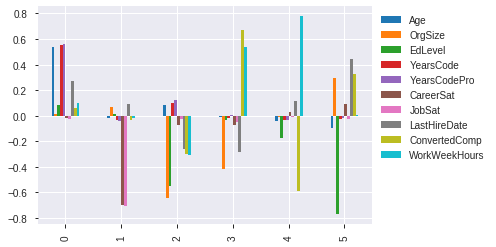

In [0]:
# What columns make up the components 1-6?
#PCA 1: Age, Years Coding, Years Coding Pro, Last Hire Date
#PCA 2: Lower career satisfaction, lower job satisfaction
#PCA 3: Smaller org size, lower education level, lower converted comp and work week hours
#PCA 4: Smaller Org Size, higher converted comp and work week hours
#PCA 5: Lower comp higher work week hours
#PCA 6: Lager org size lower educational level, high last hire date and comp
(pd.DataFrame(pca.components_, columns=X.columns)
 .iloc[0:6]
 .plot.bar()
 .legend(bbox_to_anchor=(1,1)))

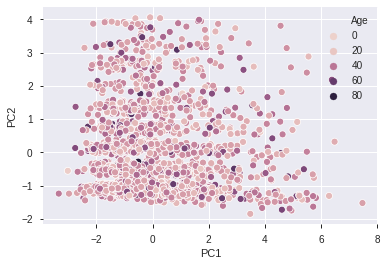

In [0]:
#Looking into how our first two principal components stack up, and if age takes any trends
sns.scatterplot(x='PC1', y='PC2', 
                data=pca_X.assign(Age=X.Age), 
                hue='Age')

#**Analysis: Part 2 - The Tools of the Trade (PCA and Clustering for Technologies Developers Use!)**
---



> The StackOverflow Developer Survey also collected some very valuable data about the types of tools respondents use in their roles in software engineering, as well as their self-identified job titles. This includes coding languages, platforms, operating systems, web frameworks, databases, and miscelaneous technologies, and titles. 



> In this second part of the analysis, we will be looking briefly at how we can cluster these tools and titles to paint a clearer picture of the various types of software developers. Please note- this portion of the analysis will include developers world-wide, not only those in the USA. 



> We try three different methods for approximating how many clusters we can group our engineers into. Please note in advance that there was no difinitive or obvious best number to use for the number of clusters. Likely more are needed.



> We also do some principal component analysis, and find that up to nearly 7% of the variance can be explained by the first principal component for technologies used. 





---














##Creating the Data Frame: Part 2


> Again, we'll store the survey as a Pandas dataframe, and in the block after that we'll select a different set of columns we'd like to use in our analysis of tools & technologies.



In [0]:
#ANALYSIS PART 2
#Storing the dataset as a Pandas Dataframe (once again, but with a different name
path = "/content/gdrive/My Drive/Data/survey_results_public.csv"
df = pd.read_csv(path)

In [0]:
#ANALYSIS PART 2
#Selecting only the columns we'd like to use for this analysis, storing as dataframe
#Removed, for now, PlatformWorkedWith, 'DatabaseWorkedWith', 'WebFrameWorkedWith','MiscTechWorkedWith', 'LanguageWorkedWith', 'Country'
df = df[['LanguageWorkedWith']]

# 'MiscTechWorkedWith', 'OpSys', 'DevType''PlatformWorkedWith' 'DatabaseWorkedWith','WebFrameWorkedWith'

##Cleaning the Data: Part 2

> See each block for a description of what is being dropped / filled / encoded and why. 

In [0]:
#ANALYSIS PART 2
#What percentage of values are missing? Checking for missing values
df.isna().mean() * 100

LanguageWorkedWith    0.0
dtype: float64

In [0]:
#ANALYSIS PART 2 (Data Cleaning)
#Dropping all empty values
df = df.dropna()

In [0]:
#ANALYSIS PART 2 (Data Encoding)
#Creating dummy variables for the high cardinality tech stack responses- eache technology now gets its own column
 
 def tweak_survey(df):
 
  #PlatformWorkedWith = df['PlatformWorkedWith'].str.get_dummies(sep=';')
  LanguageWorkedWith = df['LanguageWorkedWith'].str.get_dummies(sep=';')
  #WebFrameWorkedWith = df['WebFrameWorkedWith'].str.get_dummies(sep=';')
  #DatabaseWorkedWith = df['DatabaseWorkedWith'].str.get_dummies(sep=';')
  #MiscTechWorkedWith = df['MiscTechWorkedWith'].str.get_dummies(sep=';')
  #OpSys = df['OpSys'].str.get_dummies(sep=';')
  #DevType = df['DevType'].str.get_dummies(sep=';')

  return pd.concat([ LanguageWorkedWith], axis=1)

  #MiscTechWorkedWith, OpSys, DevType, PlatformWorkedWith


dfa = tweak_survey(df)

In [0]:
#ANALYSIS PART 2 (Data Cleaning)
#Removes the several columns 'other' columns for the tech stack 

dfb = tweak_survey(df).loc[:,~tweak_survey(df).columns.str.startswith('Other')]

In [0]:
#Can't have columns with the same name!
d = {'Windows': ['Windows1', 'Windows2']}
dfc = dfb.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)


In [0]:
#Can't have columns with the same name!
d = {'MacOS': ['MacOS1', 'MacOS2']}
dfd = dfc.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)


In [0]:
#ANALYSIS PART 2 (Data Cleaning)
#Checking for any missing values before doing principal component analysis
dfa.isna().any()

Assembly                 False
Bash/Shell/PowerShell    False
C                        False
C#                       False
C++                      False
Clojure                  False
Dart                     False
Elixir                   False
Erlang                   False
F#                       False
Go                       False
HTML/CSS                 False
Java                     False
JavaScript               False
Kotlin                   False
Objective-C              False
Other(s):                False
PHP                      False
Python                   False
R                        False
Ruby                     False
Rust                     False
SQL                      False
Scala                    False
Swift                    False
TypeScript               False
VBA                      False
WebAssembly              False
dtype: bool

##Analysis: Part 2

###Principal Component Analysis

In [0]:
#ANALYSIS PART 2 (Principal Component Analysis)
#PCA - passing in rows of features, new dataset will be the embeddings (linear combinations of columns that maximize the variance) 
#Reduces the dimensionality of the data
#Code below standardizes the data
X = dfa
std = preprocessing.StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X), columns=X.columns)
X_std

,Assembly,Bash/Shell/PowerShell,C,C#,C++,Clojure,Dart,Elixir,Erlang,F#,Go,HTML/CSS,Java,JavaScript,Kotlin,Objective-C,Other(s):,PHP,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VBA,WebAssembly
0,-0.26714,-0.758687,-0.508963,-0.669397,-0.553284,-0.120533,-0.139985,-0.120825,-0.094617,-0.106,-0.299333,0.760781,1.199205,0.691904,-0.261876,-0.224199,-0.315335,-0.597360,1.184442,-0.24733,-0.302268,-0.181543,-1.089889,-0.19817,-0.264950,-0.517948,-0.240312,-0.10829
1,-0.26714,-0.758687,-0.508963,-0.669397,1.807391,-0.120533,-0.139985,-0.120825,-0.094617,-0.106,-0.299333,0.760781,-0.833886,-1.445287,-0.261876,-0.224199,-0.315335,-0.597360,1.184442,-0.24733,-0.302268,-0.181543,-1.089889,-0.19817,-0.264950,-0.517948,-0.240312,-0.10829
2,-0.26714,-0.758687,-0.508963,-0.669397,-0.553284,-0.120533,-0.139985,-0.120825,-0.094617,-0.106,-0.299333,0.760781,-0.833886,-1.445287,-0.261876,-0.224199,-0.315335,-0.597360,-0.844279,-0.24733,-0.302268,-0.181543,-1.089889,-0.19817,-0.264950,-0.517948,-0.240312,-0.10829
3,-0.26714,-0.758687,1.964778,1.493883,1.807391,-0.120533,-0.139985,-0.120825,-0.094617,-0.106,-0.299333,-1.314440,-0.833886,-1.445287,-0.261876,-0.224199,-0.315335,-0.597360,1.184442,-0.24733,-0.302268,-0.181543,0.917525,-0.19817,-0.264950,-0.517948,-0.240312,-0.10829
4,-0.26714,-0.758687,-0.508963,-0.669397,1.807391,-0.120533,-0.139985,-0.120825,-0.094617,-0.106,-0.299333,0.760781,1.199205,0.691904,-0.261876,-0.224199,-0.315335,-0.597360,1.184442,-0.24733,-0.302268,-0.181543,0.917525,-0.19817,-0.264950,-0.517948,4.161255,-0.10829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87564,-0.26714,-0.758687,-0.508963,-0.669397,-0.553284,-0.120533,-0.139985,-0.120825,-0.094617,-0.106,-0.299333,0.760781,1.199205,0.691904,-0.261876,-0.224199,-0.315335,-0.597360,-0.844279,-0.24733,-0.302268,-0.181543,-1.089889,-0.19817,-0.264950,-0.517948,-0.240312,-0.10829
87565,-0.26714,-0.758687,-0.508963,-0.669397,-0.553284,-0.120533,-0.139985,-0.120825,-0.094617,-0.106,-0.299333,0.760781,-0.833886,0.691904,-0.261876,-0.224199,-0.315335,-0.597360,1.184442,-0.24733,-0.302268,-0.181543,-1.089889,-0.19817,-0.264950,-0.517948,-0.240312,-0.10829
87566,-0.26714,1.318067,-0.508963,-0.669397,-0.553284,-0.120533,-0.139985,-0.120825,-0.094617,-0.106,3.340759,0.760781,-0.833886,0.691904,-0.261876,-0.224199,-0.315335,-0.597360,-0.844279,-0.24733,-0.302268,-0.181543,-1.089889,-0.19817,-0.264950,-0.517948,-0.240312,9.23444
87567,-0.26714,-0.758687,-0.508963,-0.669397,-0.553284,-0.120533,-0.139985,-0.120825,-0.094617,-0.106,-0.299333,0.760781,-0.833886,0.691904,-0.261876,-0.224199,3.171229,-0.597360,-0.844279,-0.24733,-0.302268,-0.181543,-1.089889,-0.19817,-0.264950,-0.517948,-0.240312,-0.10829


In [0]:
#ANALYSIS PART 2 (Principal Component Analysis)
#Make an instance of PCA
pca = decomposition.PCA()
pca_X = pd.DataFrame(pca.fit_transform(X_std), columns=[f'PC{i+1}' for i in range(len(X.columns))])
pca_X

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
0,-0.742537,0.006574,0.031325,0.025612,-1.097594,-0.159856,-0.428665,0.398457,0.062662,0.297057,0.333791,0.511790,-0.337631,-0.313388,-0.251391,-0.531409,0.829494,-0.306922,-0.498130,0.754515,-1.307715,1.130012,0.022235,-0.080631,0.578802,0.084562,-0.058022,0.156654
1,-0.588864,1.479173,-0.743583,0.248746,0.032426,0.583588,-0.595687,-0.058014,-0.260885,0.733632,0.186927,0.624633,0.018569,-0.136582,0.040757,0.084154,0.332066,-0.358429,-0.750004,1.111864,0.365522,0.580184,0.131873,0.033287,-0.276286,0.058123,1.370652,1.596186
2,-1.837907,0.803096,0.419728,0.136435,0.342490,0.378543,-0.515580,0.160167,0.242396,0.325230,0.299669,0.202303,0.142415,0.026760,-0.155558,0.177698,0.361910,-0.081017,0.045823,-0.239251,0.029734,0.182054,-0.549464,0.011056,-0.305433,0.026971,-0.091580,1.585289
3,0.431332,1.823897,-1.944540,-0.006963,1.330625,-0.090352,0.079871,0.010660,-1.336114,0.432439,0.049416,0.021661,0.388757,0.086957,0.563264,0.332436,-1.567940,0.209986,-0.506869,1.248427,0.717269,0.135903,0.923133,0.019006,-0.696010,-0.074750,-0.528369,-0.123730
4,0.640705,-0.597773,-1.564054,-0.117031,0.248063,-0.460819,1.911156,0.821945,0.210892,0.767043,0.438568,-1.754963,0.625868,-1.317520,-0.128937,-0.167828,1.801114,-1.292114,-1.151571,1.585553,-1.292891,0.268731,0.208386,-0.055218,-1.050377,0.067086,1.557824,-0.003842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87564,-1.228983,-0.264044,0.357906,-0.329959,-0.479057,-0.306255,-0.731576,0.818185,0.251738,-0.075610,0.486763,0.234531,-0.178518,-0.195138,-0.497744,-0.243076,0.563076,-0.376883,0.042125,0.135138,-1.299938,0.338491,-0.966244,-0.106082,0.297902,0.042242,0.020977,0.143630
87565,-1.127828,-0.029277,0.118294,0.423724,-0.497251,0.666428,-0.516230,-0.283854,0.136368,0.610999,0.163582,0.730256,-0.169301,-0.251431,-0.057936,-0.123094,0.845956,-0.281697,-0.693322,0.512396,-0.218282,1.469963,-0.027774,0.016240,-0.099412,0.176313,-0.072380,0.095486
87566,1.724449,-0.526550,1.963626,1.701381,0.876775,-0.251638,-2.732137,-3.169953,3.036140,1.750942,2.786106,-2.144781,-0.463234,-0.111814,0.105616,-0.955977,1.208255,2.998692,4.612224,3.242142,0.452858,0.927122,-2.468015,-0.711681,-0.224234,-0.214453,-0.080773,0.172037
87567,-1.448342,-0.002620,0.283315,0.532571,0.603162,0.776634,-0.554329,0.126908,2.182876,-1.458782,-1.423148,0.230032,-1.105579,0.039553,-0.545612,0.318981,0.193707,-0.769605,-0.032100,0.385822,-0.246402,0.875875,-0.799283,0.014624,-0.192313,0.051646,0.029429,0.060796


In [0]:
pca.explained_variance_ratio_

array([0.08652241, 0.0784982 , 0.06124675, 0.05555911, 0.04757685,
       0.04381817, 0.04227036, 0.04020487, 0.03648769, 0.03509917,
       0.03409431, 0.03350681, 0.03291398, 0.03152829, 0.03122121,
       0.03051924, 0.02940527, 0.02915771, 0.02793399, 0.02737603,
       0.02545511, 0.0248886 , 0.02414513, 0.02218759, 0.02064263,
       0.01719414, 0.0161449 , 0.01440151])

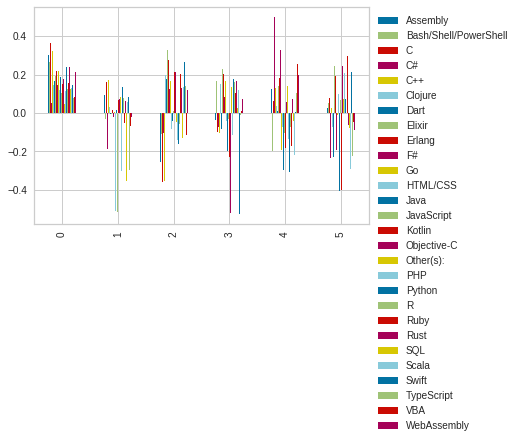

In [0]:
(pd.DataFrame(pca.components_, columns=X.columns)
 .iloc[0:6]
 .plot.bar()
 .legend(bbox_to_anchor=(1,1)))

###Determining the Appropriate Number of Clusters

In [0]:
#ANALYSIS PART 2 (Clustering)
#First method for estimating the appropriate number of clusters 
inerts = []
for i in range(2, 20):
    k = cluster.KMeans(n_clusters=i, random_state=42)
    k.fit(X_std)
    inerts.append(k.inertia_)
    
pd.Series(inerts).plot()

In [0]:
#ANALYSIS PART 2 (Clustering)
#Second method for estimating the appropriate number of clusters 
#This may take a while to run...
start, end = 21, 27
cols = 2
rows = ((end - start) // cols)
fix, axes = plt.subplots(rows, cols, figsize=(12,8))
axes = axes.reshape(cols * rows)
for i, k in enumerate(range(start, end), 0):
    ax = axes[i]
    sil = SilhouetteVisualizer(cluster.KMeans(n_clusters=k, random_state=42), ax=ax)
    sil.fit(X_std)
    sil.finalize()
plt.tight_layout()

In [0]:
#ANALYSIS PART 2 (Clustering- building a heirarchy)
#Try another mechanism
#Third method for estimating the appropriate number of clusters 
#This one also takes a while, you may need to increase RAM
fig, ax = plt.subplots(figsize=(10,8))
hierarchy.dendrogram(hierarchy.linkage(X_std, method='ward'),
                    truncate_mode='lastp', p=20, show_contracted=True)
pass  # here to hide return value of above

###Choosing and Implementing Our Desired Number of Clusters

In [0]:
#ANALYSIS PART 2 (K-Means Clustering)
# going to choose 12 clusters this time...
k13 = cluster.KMeans(n_clusters=12, random_state=42)
k13.fit(X_std)
labels = k13.predict(X_std)

In [0]:
#ANALYSIS PART 2 (K-Means Clustering)
#Assigning cluster labels to each row 
X.assign(label=labels)

,Assembly,Bash/Shell/PowerShell,C,C#,C++,Clojure,Dart,Elixir,Erlang,F#,Go,HTML/CSS,Java,JavaScript,Kotlin,Objective-C,PHP,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VBA,WebAssembly,ASP.NET,Angular/Angular.js,Django,Drupal,Express,Flask,Laravel,React.js,Ruby on Rails,Spring,Vue.js,jQuery,Cassandra,Couchbase,DynamoDB,Elasticsearch,Firebase,MariaDB,Microsoft SQL Server,MongoDB,MySQL,Oracle,PostgreSQL,Redis,SQLite,label
0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7
4,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,7
7,0,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,1,0,1,1,5
8,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,4
9,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1,0,0,0,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88871,1,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,6
88872,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
88876,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,7
88878,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,10


In [0]:
#ANALYSIS PART 2 (K-Means Clustering)
#Looking at tool mean usage and variance for each cluster
(X.assign(label=labels)
  .groupby('label')
  .agg(['mean', 'var'])
  .T
)

label                             0         1   ...        10        11
Assembly              mean  0.062129  0.002257  ...  0.003878  0.222395
                      var   0.058295  0.002252  ...  0.003863  0.173205
Bash/Shell/PowerShell mean  0.418913  0.303209  ...  0.282462  0.629860
                      var   0.243536  0.211294  ...  0.202703  0.233500
C                     mean  0.357698  0.149642  ...  0.091068  0.415241
...                              ...       ...  ...       ...       ...
PostgreSQL            var   0.236697  0.166535  ...  0.214724  0.207860
Redis                 mean  0.217908  0.173977  ...  0.166750  0.505443
                      var   0.170502  0.143723  ...  0.138962  0.250360
SQLite                mean  0.591138  0.295457  ...  0.169627  0.441680
                      var   0.241804  0.208182  ...  0.140871  0.246983

[104 rows x 12 columns]

In [0]:
#ANALYSIS PART 2 (K-Means Clustering)
#How many developers in each cluster?
pd.Series(labels).value_counts().sort_index()

0      2189
1     10191
2     12600
3      3800
4       751
5      7415
6      2867
7      7056
8      3333
9      2176
10     7994
11      643
dtype: int64

In [0]:
#ANALYSIS PART 2 (K-Means Clustering)
# Add coloring to aid impact to clusters
(X.assign(label=labels)
  .groupby('label')
  .mean()
  .T
 .style.background_gradient(cmap='RdBu', axis=1)
)

label,0,1,2,3,4,5,6,7,8,9,10,11
Assembly,0.0621288,0.00225689,0.0047619,0.0144737,0.235686,0.00364127,0.981165,0.00325964,0.00840084,0.0422794,0.00387791,0.222395
Bash/Shell/PowerShell,0.418913,0.303209,0.290556,0.415789,0.55526,0.338773,0.65225,0.468254,0.593459,0.542739,0.282462,0.62986
C,0.357698,0.149642,0.080873,0.114474,0.400799,0.105462,0.765609,0.238379,0.209721,0.170037,0.0910683,0.415241
C#,0.412517,0.182514,0.961746,0.15,0.479361,0.129872,0.489362,0.135488,0.245725,0.210938,0.125219,0.348367
C++,0.372773,0.166814,0.13627,0.122368,0.450067,0.111935,0.703872,0.25907,0.218122,0.188419,0.116462,0.399689
Clojure,0.0114207,0.00274752,0.00253968,0.0242105,0.0492676,0.011733,0.0177886,0.0157313,0.0246025,0.0445772,0.0288967,0.14619
Dart,0.0566469,0.014032,0.00928571,0.0123684,0.0585885,0.0121376,0.039414,0.0151644,0.0561056,0.0234375,0.0273955,0.118196
Elixir,0.0118776,0.00461191,0.00333333,0.0823684,0.0292943,0.00445044,0.00906871,0.00907029,0.0288029,0.0206801,0.0117588,0.508554
Erlang,0,0,0,0,0,0,0,0,0,0,0,0.998445
F#,0.0146185,0.000883132,0.0293651,0.00421053,0.0466045,0.00229265,0.0268573,0.00354308,0.0138014,0.0229779,0.00312735,0.125972


##Developer Types

**Here are the clusters of developers we found, their counts, and their descriptions:**

1) DevOps / Cloud / SRE / System Admin: 3423

2) Full Stack Windows / C#.NET Developer: 11019

3) Full Stack Java Developer: 4643

4) Erlang/Elixer Developers & Business Executive: 493

5) Full Stack & Front End Web Developer: 4434

6) Data Scientists & Machine Learning: 2552

7) Back-end Data Engineer: 1478

8) Full Stack Ruby/Rails Developer: 2244

9) Enterprise, Desktop, Embedded/Hardware, or Game Developer: 3713

10) iOS Developer: 2024

11) Node & JavaScript Developer: 5490

12) Android Developer: 1000



#**Conclusion**



> Overall, this analysis was a great starting point for getting to know the developer community a bit better, or at least those who chose to respond to the 2019 StackOverflow Developer Survey, answering the questions we're intersted in investigating.


> If we can assume that most people are answering honestly, I was very surprised that compensation was generally higher than I had anticipated. Not only is the mean relatively high, but there are more high-income outliers than I thought. It was equally surprising that compensation was not closely tied to years of experience, age, or years spent coding professionally. It's possible there is some other factor at play- in the future, I may look at developer type to see if there is a strong assocaition there, but I'm not counting on it. Furthermore, it's possible that people were more likely to over-report than under-report their compensation, thus giving the average a bit of a lift. Or, that people with generally lower compensation more often than not simply chose not to report their compensation. 


> I also found something very interesting in the relationship between time spent in a role and job satisfaction. It took a few tries with visualizing the data to get the story to shine through, but I made a breakthrough with using violin plots. The more years since your last job move, the less satisfied you may be with your job. Many times in recruiting, I find myself making the assumption that someone who's been in a role for many years is satisfied and not looking for a change. This might not always be the case!




> In general, I was pretty satisfied with the cluster analysis of the different types of developers based on the tools they use. I did not suspect that C# developers were so cohesive in terms of the tools they use, nor so numerous. Other developer types seemed to show more diversity in the range of their tools that I had anticipated, but I was still able to identify the general types of developers base on their tools and probable functions. In the future, I think I may need to use more clusters. 



> For the future, I want to find a way to incorporate both aspects (Parts 1 and 2) in the same analysis, rather than setting up two different dataframes. One barrier to doign this now was that some calculations -especially with the clustering- simply took too long, timed out, or ran out of usable ram. I will also consider finding ways to format the data to make these calculations run easier and faster.








